#                                      Machine Learning Models

## Importing Libraries

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import os

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, auc
from sklearn.metrics import accuracy_score, make_scorer, roc_curve
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix


import warnings
warnings.filterwarnings('ignore')

saved_files_path = "saved_files/"

## Loading the files

In [3]:
#Loading the files
X_train, y_train = pickle.load(open(saved_files_path+'final_train_fe.pkl', 'rb'))
X_test, y_test = pickle.load(open(saved_files_path+'final_test_fe.pkl', 'rb'))

saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))
saved_mode_values = pickle.load(open(saved_files_path+'saved_mode_values.pkl', 'rb'))

## Plan of action

1. Import libraries
2. Import train and test dataset
3. Write functions for:
    a. Confusion matrix visualization
    b. Calculate accuracy, recall, prescision, F1 score, ROC-AUC Score
    c. visualization of results - graphs between different results
    d. Pretty table
4. Logistic Regression

In [4]:
X_train.head()

,sttl,swin,stcpb,dtcpb,smean,trans_depth,response_body_len,tcprtt,synack,ackdat,...,proto_esp,proto_stp,proto_wb-expak,proto_compaq-peer,proto_rvd,proto_ip,proto_aris,proto_rtp,proto_igmp,proto_udt
1921074,-0.037165,-1.196075,-0.887140,-0.887240,0.051082,-0.237366,-0.089758,-0.135307,-0.128343,-0.121503,...,0,0,0,0,0,0,0,0,0,0
2012474,-0.037165,-1.196075,-0.887140,-0.887240,0.051082,-0.237366,-0.089758,-0.135307,-0.128343,-0.121503,...,0,0,0,0,0,0,0,0,0,0
115171,-0.425838,0.836077,-0.464715,-0.464092,-0.027936,2.611620,-0.006926,-0.121203,-0.108315,-0.115967,...,0,0,0,0,0,0,0,0,0,0
2164402,-0.425838,-1.196075,-0.887140,-0.887240,-0.337423,-0.237366,-0.089758,-0.135307,-0.128343,-0.121503,...,0,0,0,0,0,0,0,0,0,0
1889220,2.562925,-1.196075,-0.887140,-0.887240,-0.442781,-0.237366,-0.089758,-0.135307,-0.128343,-0.121503,...,0,0,0,0,0,0,0,0,0,0


## Utility functions

In [5]:
def calculate_False_Alarm_Rate(y_true, y_pred):
    '''
    This function is used to calculate the False Alarm Rate. We take the average of False positive rate and False Negative Rate
    to calculate the False Alarm Rate.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #False positive rate
    FPR = fp/(tp+tn)
    #False negative rate
    FNR = fn/(tn+tp)
    #False Alarm rate
    FAR = (FPR + FNR)/2
    return FAR

def get_precision(y_true, y_pred):
    '''
    This function returns the precision and takes y_true and y_pred as input.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fp)

def get_recall(y_true, y_pred):
    '''
    This function returns the recall and takes y_true and y_pred as input.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fn)

In [6]:
def hyperparamter_tuning(clf, X_train, y_train, param_grid, cv=3, method='GridSearchCV'):
    '''
    This function is used for tuning the hyper parameter
    '''
    #initializing scoring
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'accuracy': 'accuracy',
               'False_alaram_rate': make_scorer(calculate_False_Alarm_Rate, greater_is_better=False),
               'Precision': make_scorer(get_precision, greater_is_better=True),
               'Recall': make_scorer(get_recall, greater_is_better=True)}
    
    #Hyper paramters tuning on GridSearchCV method
    if method == 'GridSearchCV':
        clf_cv = GridSearchCV(clf, param_grid, scoring=scoring,
                              cv=cv, refit='accuracy',
                              verbose=3,
                              n_jobs=-1,
                              return_train_score=True)
        results = clf_cv.fit(X_train, y_train)
    
    #Hyper paramters tuning on RandomizedSearchCV method
    elif method == 'RandomizedSearchCV':
        clf_cv = RandomizedSearchCV(clf, param_grid, scoring, 
                                    refit='accuracy', cv=cv,
                                   verbose=3, n_jobs=-1,
                                   return_train_score=True)
        results = clf_cv.fit(X_train, y_train)
        
    return results

In [18]:
def hyperparamter_tuning_with_new_classes(clf, X_train, y_train, param_grid, cv=3, method='GridSearchCV'):
    '''
    This function is used for tuning the hyper parameter
    '''
    #initializing scoring
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'accuracy': 'accuracy',
               'False_alaram_rate': make_scorer(calculate_False_Alarm_Rate, greater_is_better=False),
               'Precision': make_scorer(get_precision, greater_is_better=True),
               'Recall': make_scorer(get_recall, greater_is_better=True)}
    
    #Hyper paramters tuning on GridSearchCV method
    if method == 'GridSearchCV':
        clf_cv = HalvingGridSearchCV(clf, param_grid, scoring='roc_auc',
                              cv=cv, refit=True,
                              verbose=3,
                              n_jobs=-1,
                              min_resources='exhaust',
                              factor=3,
                              return_train_score=True)
        results = clf_cv.fit(X_train, y_train)
    
    #Hyper paramters tuning on RandomizedSearchCV method
    elif method == 'RandomizedSearchCV':
        clf_cv = RandomizedSearchCV(clf, param_grid, scoring, 
                                    refit='accuracy', cv=cv,
                                   verbose=3, n_jobs=-1,
                                   return_train_score=True)
        results = clf_cv.fit(X_train, y_train)
        
    return results

In [8]:
def plot_roc_curve_(y_true_train, y_pred_train, y_true_test, y_pred_test):
    test_fpr = [0,0]
    test_tpr = [0,0]
    train_fpr = [0,0]
    train_tpr = [0,0]

    for i in range(2):
        test_fpr[i], test_tpr[i], threshold = roc_curve(y_true_test, y_pred_test)
        train_fpr[i], train_tpr[i], threshold = roc_curve(y_true_train, y_pred_train)

    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(test_fpr[0], test_tpr[0], color='blue', label="ROC curve for test data class 0.")
    plt.plot(test_fpr[1], test_tpr[1], color='green', label="ROC curve for test data class 1.")
    plt.ylabel("True postive rate")
    plt.xlabel("False positive rate")
    plt.title("ROC Curve for test data")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_fpr[0], train_tpr[0], color='blue', label="ROC curve for train data class 0.")
    plt.plot(train_fpr[1], train_tpr[1], color='green', label="ROC curve for train data class 1.")
    plt.ylabel("True postive rate")
    plt.xlabel("False positive rate")
    plt.title("ROC Curve for Train data")
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
def plot_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred):
    #For train
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred), 
                annot=True, fmt='d',xticklabels=['Normal Traffic', 'Malicious Traffic'],
                yticklabels=['Normal Traffic', 'Malicious Traffic'])
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title("Confusion Matrix for training data.")
    
    #For test
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
                annot=True, fmt='d', xticklabels=['Normal Traffic', 'Malicious Traffic'],
                yticklabels=['Normal Traffic', 'Malicious Traffic'])
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title("Confusion Matrix for testing data.")
    plt.show()

In [21]:
def evaluate_results(clf, X_train, y_train, X_test, y_test, model_name):
    '''
    This function evaluates accuracy, precision, recall, f1 score, auc_score and False Alarm Rate
    
    It also out puts confusion matrix and the ROC curve
    '''
    #Training the classifier and predicting train and test data
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    #Plan of Action
        #Calculate below mentioned for train and test
        #Calculate accuracy
        #Calculat precision
        #Calculate recall
        #Calculate F1 Score
        #Calculate False Alarm rate
        #Calculate ROC_AUC score
    
    #Scores for train dataset
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_precision = get_precision(y_train, y_train_pred)
    train_recall = get_recall(y_train, y_train_pred)
    train_falseAlarmRate = calculate_False_Alarm_Rate(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    
    #Scores for test dataset
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = get_precision(y_test, y_test_pred)
    test_recall = get_recall(y_test, y_test_pred)
    test_falseAlarmRate = calculate_False_Alarm_Rate(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    #Printing the results in a table
    # Specify the Column Names while initializing the Table
    results_table = PrettyTable(["Classifier Name", "Dataset Category(train/test)", "Accuracy", "F1_Score", "Precision", "Recall", "False Alarm Rate", "ROC_AUC Score"])
    results_table.add_row([model_name, 'train set', train_accuracy, train_f1, train_precision, train_recall, train_falseAlarmRate, train_roc_auc])
    results_table.add_row([model_name, 'test set', test_accuracy, test_f1, test_precision, test_recall, test_falseAlarmRate, test_roc_auc])
    print(results_table)
    
    #Plot AUC score - train and test
    plot_roc_curve_(y_train, y_train_pred, y_test, y_test_pred)
    
    #Plot Confusion matrix - train and test
    plot_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred)
    
    #Returning score
    return clf, test_accuracy, test_f1, test_falseAlarmRate, test_precision, test_recall, test_roc_auc

## Logistic Regression

Training a logistic Regression model and tuning the below mentioned hyperparameters:
1. Penalty: 'l1' and 'l2'
2. C : np.logspace(-6,1,8)

In [9]:
#Hyperparameter tuning of Logistic Regression on different values of penalty and C
clf_lr = LogisticRegression()
params = {'penalty' : ['l1', 'l2'],
          'C' : np.logspace(-6, 1, 8)}
lr_clf = hyperparamter_tuning_with_new_classes(clf_lr, X_train, y_train, params, cv=3, method='GridSearchCV')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1e-06, penalty=l1 .............................................
[CV]  C=1e-06, penalty=l1, auc=0.5, f1=0.0, accuracy=0.8735122079409933, False_alaram_rate=-0.07240184562340495, Precision=nan, Recall=0.0, total= 1.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] C=1e-06, penalty=l1 .............................................
[CV]  C=1e-06, penalty=l1, auc=0.5, f1=0.0, accuracy=0.873513310814003, False_alaram_rate=-0.07240112292514903, Precision=nan, Recall=0.0, total= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV] C=1e-06, penalty=l1 .............................................
[CV]  C=1e-06, penalty=l1, auc=0.5, f1=0.0, accuracy=0.873513310814003, False_alaram_rate=-0.07240112292514903, Precision=nan, Recall=0.0, total= 1.4min
[CV] C=1e-06, penalty=l2 .............................................
[CV]  C=1e-06, penalty=l2, auc=0.9840411625218468, f1=0.7335297890734664, accuracy=0.9153608347875384, False_alaram_rate=-0.046232677866377636, Precision=0.6094693751448212, Recall=0.921004715439563, total= 2.5min
[CV] C=1e-06, penalty=l2 .............................................
[CV]  C=1e-06, penalty=l2, auc=0.9841767340554628, f1=0.7345320527138709, accuracy=0.9157769168989465, False_alaram_rate=-0.04598449772366741, Precision=0.6107675996935482, Recall=0.9212022176831047, total= 1.2min
[CV] C=1e-06, penalty=l2 .............................................
[CV]  C=1e-06, penalty=l2, auc=0.9844939942369126, f1=0.736853396011715, accuracy=0.9166952095242594, False_alaram_rate=-0.045437561803

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 515.5min finished


In [10]:
#Training the classifier on best model parameters
print(lr_clf.best_params_)
clf_lr_best = LogisticRegression(C = lr_clf.best_params_['C'], penalty = lr_clf.best_params_['penalty'])

{'C': 10.0, 'penalty': 'l2'}


+---------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|   Classifier Name   | Dataset Category(train/test) |      Accuracy      |      F1_Score      |     Precision      |       Recall       |   False Alarm Rate   |   ROC_AUC Score    |
+---------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
| Logistic Regression |          train set           | 0.989407657549037  | 0.9588418190370928 | 0.9427861257765143 | 0.9754538451362897 | 0.005352870664657226 | 0.9993003664726899 |
| Logistic Regression |           test set           | 0.9894234157268867 | 0.9589066240411164 | 0.9427767918909977 | 0.9755979893241203 | 0.005344822097899872 | 0.9993018251655464 |
+---------------------+------------------------------+--------------------+----------

<Figure size 432x288 with 0 Axes>

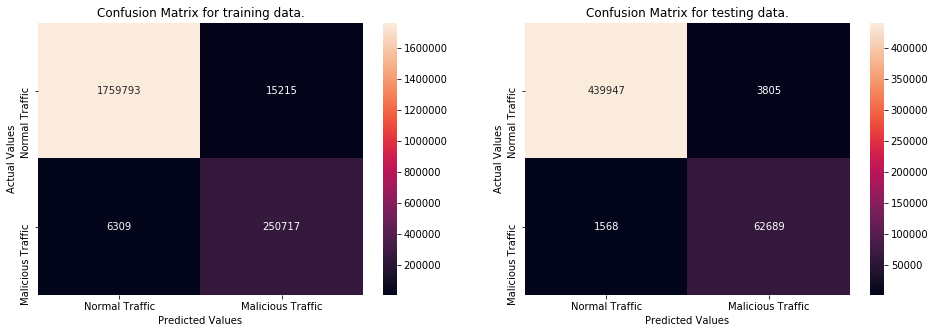

In [24]:
#Results for our model
clf, test_accuracy, test_f1, test_falseAlarmRate, test_precision, test_recall, test_roc_auc = evaluate_results(clf_lr_best, X_train, y_train, X_test, y_test, 'Logistic Regression')

### Results

We get 98.94% accuracy for test data. We get F1 score of 0.95884, AUC score of 0.9993 and finally the False Alarm Rate of 0.005352. 

## Observations
1. Hyper parameters C and penalty have been tuned and studied for best results.
2. It can be seen that best results are acheived with C=10.0 and using L2 regularization.
3. We get 98.94% accuracy for test data. We get F1 score of 0.95884, AUC score of 0.9993 and finally the False Alarm Rate of 0.005352. 
4. Since the performance of the model in terms of F1 score, accuracy and AUC score is very close we can say that our model is not overfitting.
5. Also, we have very less False Alam rate which means we have a good model.

## RandomForestClassifier

In [21]:
clf_rfc = RandomForestClassifier()
params = {'n_estimators' : [100, 150, 200],
          'min_samples_split':[2, 4, 6],
          'max_depth':[20, 22, 24]}
rfc_clf = hyperparamter_tuning_with_new_classes(clf_rfc, X_train, y_train, params, cv=2)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 75260
max_resources_: 2032034
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 75260
Fitting 2 folds for each of 27 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 9
n_resources: 225780
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 677340
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 2032020
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [22]:
print(rfc_clf.best_params_)#Best Parameters

{'max_depth': 24, 'min_samples_split': 4, 'n_estimators': 200}


+-----------------+------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+
| Classifier Name | Dataset Category(train/test) |      Accuracy      |      F1_Score      |     Precision      |       Recall       |    False Alarm Rate   |   ROC_AUC Score    |
+-----------------+------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+
|  Random Forest  |          train set           | 0.9978902912057573 | 0.9916308271366574 | 0.9951569485641293 | 0.9881296055651957 | 0.0010570845376666814 | 0.9999665150099949 |
|  Random Forest  |           test set           | 0.9941812054510846 | 0.9769422776911076 | 0.9793409755563549 | 0.9745553013679443 |  0.002926425543457815 | 0.9997729384202334 |
+-----------------+------------------------------+--------------------+--------------------+--------

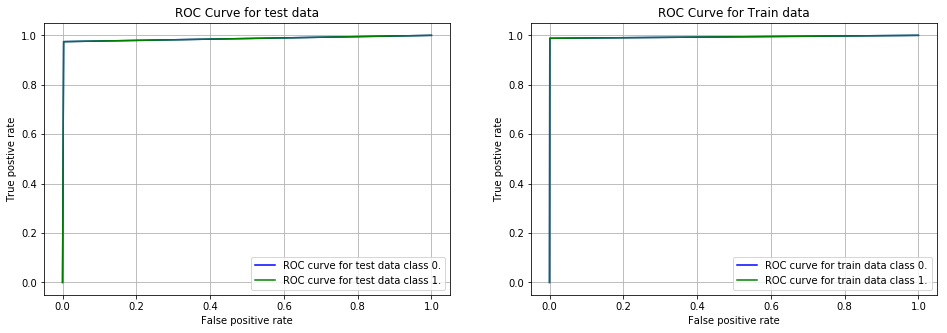

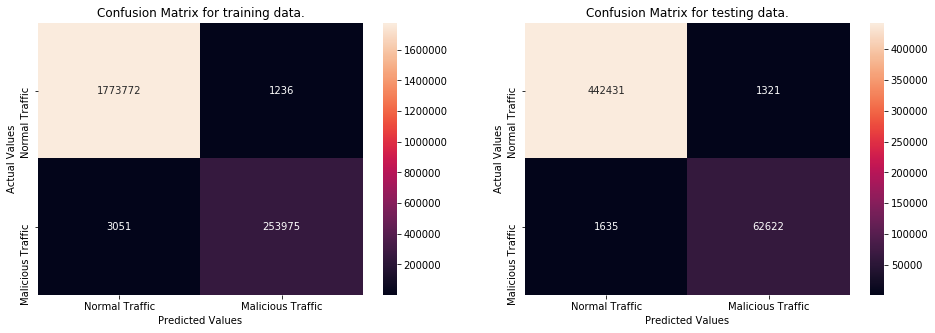

In [45]:
#Training with best parameters
clf_rfc_best = RandomForestClassifier(max_depth=24, min_samples_split=4, n_estimators=200)
clf_rfc, test_accuracy_rfc, test_f1_rfc, test_falseAlarmRate_rfc, test_precision_rfc, test_recall_rfc, test_roc_auc_rfc = evaluate_results(clf_rfc_best, X_train, y_train, X_test, y_test, "Random Forest")

## Conclusions
We have acheived 99.4% accuracy on test data with 0.9997 as ROC_AUC Score and 0.977 F1 score. We also succeeded in getting a very low score of 0.0029 False Alarm Rate on unseen test data.

In [46]:
#Saving the model
pickle.dump(clf_rfc, open(os.path.join(saved_files_path, 'model_rfc.pkl'), 'wb'))

## Getting the important features

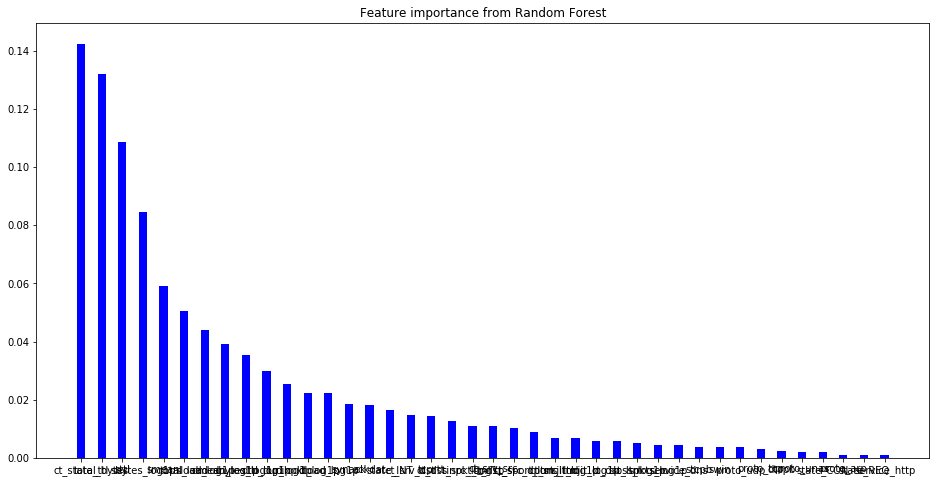

These top 40 important features are:  ['ct_state_ttl', 'total_bytes', 'sttl', 'sbytes_log1p', 'smean', 'total_load', 'sload_log1p', 'dmean_log1p', 'dbytes_log1p', 'dttl_log1p', 'dur_log1p', 'dinpkt_log1p', 'dload_log1p', 'synack', 'ackdat', 'state_INT', 'ct_srv_dst', 'tcprtt', 'ct_dst_src_ltm', 'sinpkt_log1p', 'ct_srv_src', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'ct_src_ltm', 'sjit_log1p', 'djit_log1p', 'ct_dst_ltm', 'sloss_log1p', 'spkts_log1p', 'service_dns', 'stcpb', 'swin', 'proto_udp', 'proto_tcp', 'dtcpb', 'proto_unas', 'state_CON', 'proto_arp', 'state_REQ', 'service_http']


In [57]:
#Getting and sorting the important features
sorted_important_features = np.flip(np.sort(clf_rfc.feature_importances_))
rfc_important_features = [X_train.columns.values[i] for i in arg_important_features[:40]]
plt.figure(figsize=(16,8))
plt.bar(rfc_important_features, sorted_important_features[:40], color ='blue', width = 0.4)
plt.title("Feature importance from Random Forest")
plt.show()
print("These top 40 important features are: ",rfc_important_features)

In [10]:
#Saving important features
saved_parameters = pickle.load(open('saved_files/saved_parameters.pkl', 'rb'))
saved_parameters['important_features'] = ['ct_state_ttl', 'total_bytes', 'sttl', 'sbytes_log1p', 'smean', 'total_load', 'sload_log1p', 'dmean_log1p', 'dbytes_log1p', 'dttl_log1p', 'dur_log1p', 'dinpkt_log1p', 'dload_log1p', 'synack', 'ackdat', 'state_INT', 'ct_srv_dst', 'tcprtt', 'ct_dst_src_ltm', 'sinpkt_log1p', 'ct_srv_src', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'ct_src_ltm', 'sjit_log1p', 'djit_log1p', 'ct_dst_ltm', 'sloss_log1p', 'spkts_log1p', 'service_dns', 'stcpb', 'swin', 'proto_udp', 'proto_tcp', 'dtcpb', 'proto_unas', 'state_CON', 'proto_arp', 'state_REQ', 'service_http']
saved_parameters['all_columns'] = list(X_train.columns)
pickle.dump(saved_parameters, open('saved_files/saved_parameters.pkl', 'wb'))

## Now we will train Random Forest on these 40 important features.

In [14]:
#Getting top 40 features
X_train_imp = X_train[saved_parameters['important_features']]
X_test_imp = X_test[saved_parameters['important_features']]

In [19]:
import timeit
start = timeit.timeit()

clf_rfc_imp = RandomForestClassifier()
params = {'n_estimators' : [100, 200, 300],
          'min_samples_split':[2, 4, 6],
          'max_depth':[20, 24, 28]}
rfc_clf_imp = hyperparamter_tuning_with_new_classes(clf_rfc_imp, X_train_imp, y_train, params, cv=2)

end = timeit.timeit()
print("Total time taken is ",(end - start)/60," minutes.")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 75260
max_resources_: 2032034
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 75260
Fitting 2 folds for each of 27 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 9
n_resources: 225780
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 677340
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 2032020
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Total time taken is  -9.700500001296556e-05  minutes.


{'max_depth': 24, 'min_samples_split': 6, 'n_estimators': 300}
+---------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+
|         Classifier Name         | Dataset Category(train/test) |      Accuracy      |      F1_Score      |     Precision      |       Recall       |    False Alarm Rate   |   ROC_AUC Score    |
+---------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+
| Random Forest with imp features |          train set           | 0.9982795563460061 | 0.9931787761600569 | 0.9961603494434268 | 0.9902149977045124 | 0.0008617043407616717 | 0.9999779779615259 |
| Random Forest with imp features |           test set           | 0.9943544307285894 | 0.9776423081120691 | 0.9794442448571562 | 0.9758469894330579 | 0.

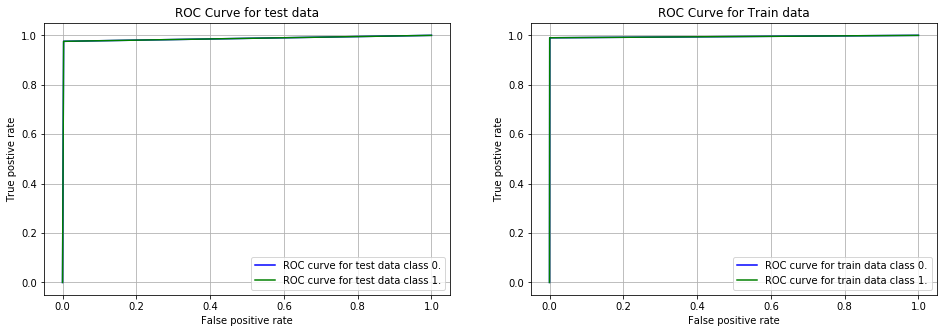

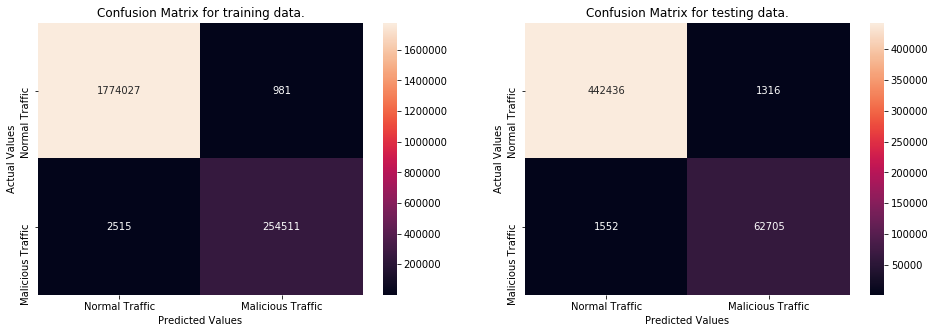

In [35]:
import timeit
start = timeit.timeit()

print(rfc_clf_imp.best_params_)#Best Parameters

#Training with best parameters
clf_rfc_best_imp = RandomForestClassifier(max_depth=rfc_clf_imp.best_params_['max_depth'], min_samples_split=rfc_clf_imp.best_params_['min_samples_split'], n_estimators=rfc_clf_imp.best_params_['n_estimators'])
clf_rfc_imp, test_accuracy_rfc_imp, test_f1_rfc_imp, test_falseAlarmRate_rfc_imp, test_precision_rfc_imp, test_recall_rfc_imp, test_roc_auc_rfc_imp = evaluate_results(clf_rfc_best_imp, X_train_imp, y_train, X_test_imp, y_test, "Random Forest with imp features")

end = timeit.timeit()

In [43]:
#Saving the model
pickle.dump(clf_rfc_imp, open(os.path.join(saved_files_path, 'model_rfc_imp.pkl'), 'wb'))

## Observations
1. Hyper parameters max_depth, min_samples_split, and n_estimators have been tuned and studied for best results.
2. It can be seen that best results are acheived with max_depth : 24, min_samples_split: 6, and n_estimators: 300.
3. We get even better 99.44% accuracy for test data. We get F1 score of 0.977, AUC score of 0.9997 and finally the False Alarm Rate of 0.00283.
4. Since the performance of the model in terms of F1 score, accuracy and AUC score is very close we can say that our model is not overfitting.
5. Also, we have very less False Alam rate which means we have a really good model.

## XGBoost

In [37]:
import timeit
#to calculate execution time
start = timeit.timeit()

#XGBoost classifier
clf_xgb_imp = xgb.XGBClassifier()
#Different parameters values to tune
params = {'learning_rate': [0.01, 0.1, 1.0],
          'max_depth': [4,8,12],
          'subsample':[0.1, 0.5, 1],
          'n_estimators':[200, 300, 400]}

#Hyper parameter tuning
xgb_clf_imp = hyperparamter_tuning_with_new_classes(clf_xgb_imp, X_train, y_train, params, cv=2)

end = timeit.timeit()
print("Total time taken is ",(end - start)," minutes.")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 25086
max_resources_: 2032034
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 25086
Fitting 2 folds for each of 81 candidates, totalling 162 fits
----------
iter: 1
n_candidates: 27
n_resources: 75258
Fitting 2 folds for each of 27 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 9
n_resources: 225774
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 3
n_resources: 677322
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 4
n_candidates: 1
n_resources: 2031966
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Total time taken is  0.018853799996577436  minutes.


{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1}
+---------------------------+------------------------------+--------------------+--------------------+-------------------+--------------------+-----------------------+--------------------+
|      Classifier Name      | Dataset Category(train/test) |      Accuracy      |      F1_Score      |     Precision     |       Recall       |    False Alarm Rate   |   ROC_AUC Score    |
+---------------------------+------------------------------+--------------------+--------------------+-------------------+--------------------+-----------------------+--------------------+
| XGBoost with imp features |          train set           | 0.9953357079655163 | 0.9814814814814815 | 0.985795922852904 | 0.9772046407756414 |  0.002343074802378772 | 0.999856800380579  |
| XGBoost with imp features |           test set           | 0.9940375072095179 | 0.9763376012624112 | 0.980204542602585 | 0.9725010504692095 | 0.0029991286783634993 | 

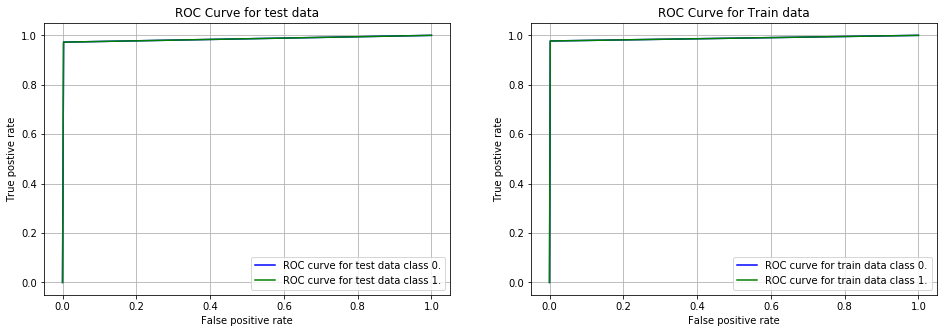

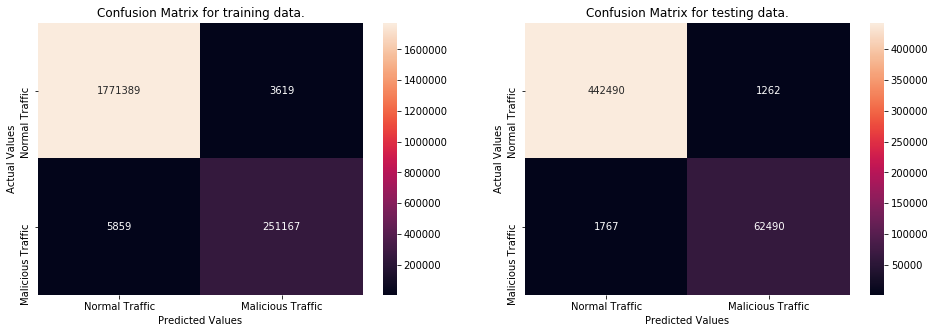

Time taken:  -0.02985500001523178  seconds.


In [38]:
import timeit
start = timeit.timeit()

#Printing out the best parameters
print(xgb_clf_imp.best_params_)#Best Parameters

#Training with best parameters
clf_xgb_best_imp = xgb.XGBClassifier(max_depth=xgb_clf_imp.best_params_['max_depth'],learning_rate=xgb_clf_imp.best_params_['learning_rate'],n_estimators=xgb_clf_imp.best_params_['n_estimators'], subsample=xgb_clf_imp.best_params_['subsample'])

#Getting the results
clf_xgb_imp, test_accuracy_xgb_imp, test_f1_xgb_imp, test_falseAlarmRate_xgb_imp, test_precision_xgb_imp, test_recall_xgb_imp, test_roc_auc_xgb_imp = evaluate_results(clf_xgb_best_imp, X_train_imp, y_train, X_test_imp, y_test, "XGBoost with imp features")

end = timeit.timeit()
print("Time taken: ", (end-start)," seconds.")

In [41]:
#Saving the model
pickle.dump(clf_xgb_imp, open(os.path.join(saved_files_path, 'model_xgb.pkl'), 'wb'))

## Observations
1. Hyper parameters learning_rate, max_depth, n_estimators, and subsample have been tuned and studied for best results.
2. It can be seen that best results are acheived with learning_rate: 0.1, max_depth: 8, n_estimators: 200, 'subsample: 1.
3. We get 99.40% accuracy for test data. We get F1 score of 0.9763, AUC score of 0.9997 and finally the False Alarm Rate of 0.00299.
4. Since the performance of the model in terms of F1 score, accuracy and AUC score is very close we can say that our model is not overfitting.
5. Also, we have very less False Alam rate which means we have a really good model.